In [1]:
import findspark
findspark.init('C:/Users\gaborstefanics\Documents\GitHub\learnPySark\spark\spark-2.4.4-bin-hadoop2.7')

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('k_means').getOrCreate()

In [2]:
import pyspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.functions import * 
from pyspark.sql.types import *
from pyspark.sql.functions import rand, randn
from pyspark.ml.clustering import KMeans

In [3]:
df=spark.read.csv('iris_dataset.csv',inferSchema=True,header=True)

In [4]:
print((df.count(),len(df.columns)))

(150, 5)


In [5]:
df.columns

['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

In [6]:
df.printSchema()

root
 |-- sepal_length: double (nullable = true)
 |-- sepal_width: double (nullable = true)
 |-- petal_length: double (nullable = true)
 |-- petal_width: double (nullable = true)
 |-- species: string (nullable = true)



In [7]:
df.orderBy(rand()).show(10,False)

+------------+-----------+------------+-----------+----------+
|sepal_length|sepal_width|petal_length|petal_width|species   |
+------------+-----------+------------+-----------+----------+
|4.8         |3.0        |1.4         |0.1        |setosa    |
|7.7         |2.8        |6.7         |2.0        |virginica |
|6.1         |2.8        |4.0         |1.3        |versicolor|
|7.6         |3.0        |6.6         |2.1        |virginica |
|5.7         |2.9        |4.2         |1.3        |versicolor|
|5.4         |3.9        |1.7         |0.4        |setosa    |
|7.7         |3.0        |6.1         |2.3        |virginica |
|7.2         |3.2        |6.0         |1.8        |virginica |
|5.7         |3.0        |4.2         |1.2        |versicolor|
|5.5         |2.4        |3.8         |1.1        |versicolor|
+------------+-----------+------------+-----------+----------+
only showing top 10 rows



In [8]:
df.select('species').distinct().count()

3

In [9]:
df.groupBy('species').count().orderBy('count',ascending=False).show(10,False)

+----------+-----+
|species   |count|
+----------+-----+
|virginica |50   |
|versicolor|50   |
|setosa    |50   |
+----------+-----+



In [10]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [11]:
input_cols=['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

In [12]:
# Transform all features into a vector using VectorAssembler
vec_assembler = VectorAssembler(inputCols = input_cols, outputCol='features')
final_data = vec_assembler.transform(df)

In [14]:
errors=[]

for k in range(2,10):
    kmeans = KMeans(featuresCol='features',k=k)
    model = kmeans.fit(final_data)
    intra_distance = model.computeCost(final_data)
    errors.append(intra_distance)
    print("With K={}".format(k))
    print("Within Set Sum of Squared Errors = " + str(intra_distance))
    print('--'*30)

With K=2
Within Set Sum of Squared Errors = 152.368706477
------------------------------------------------------------
With K=3
Within Set Sum of Squared Errors = 78.945065826
------------------------------------------------------------
With K=4
Within Set Sum of Squared Errors = 71.6570902675
------------------------------------------------------------
With K=5
Within Set Sum of Squared Errors = 49.7132542127
------------------------------------------------------------
With K=6
Within Set Sum of Squared Errors = 39.2778790001
------------------------------------------------------------
With K=7
Within Set Sum of Squared Errors = 36.842515873
------------------------------------------------------------
With K=8
Within Set Sum of Squared Errors = 34.7662394003
------------------------------------------------------------
With K=9
Within Set Sum of Squared Errors = 31.4880961244
------------------------------------------------------------


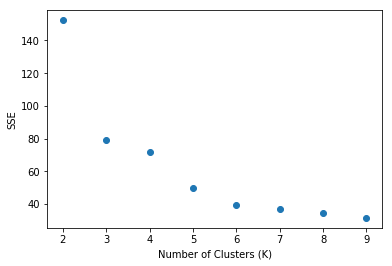

In [15]:
cluster_number = range(2,10)
plt.scatter(cluster_number,errors)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('SSE')
plt.show()

In [16]:
#Selecting k =3 for kmeans clustering
kmeans = KMeans(featuresCol='features',k=3,)

In [17]:
model = kmeans.fit(final_data)

In [18]:
model.transform(final_data).groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   61|
|         2|   39|
|         0|   50|
+----------+-----+



In [19]:
predictions=model.transform(final_data)

In [20]:
predictions.columns

['sepal_length',
 'sepal_width',
 'petal_length',
 'petal_width',
 'species',
 'features',
 'prediction']

In [21]:
predictions.groupBy('species','prediction').count().show()

+----------+----------+-----+
|   species|prediction|count|
+----------+----------+-----+
| virginica|         2|   36|
|    setosa|         0|   50|
| virginica|         1|   14|
|versicolor|         1|   47|
|versicolor|         2|    3|
+----------+----------+-----+



In [22]:
pandas_df = predictions.toPandas()
pandas_df.sample(5)

,sepal_length,sepal_width,petal_length,petal_width,species,features,prediction
119,6.0,2.2,5.0,1.5,virginica,"[6.0, 2.2, 5.0, 1.5]",1
60,5.0,2.0,3.5,1.0,versicolor,"[5.0, 2.0, 3.5, 1.0]",1
37,4.9,3.1,1.5,0.1,setosa,"[4.9, 3.1, 1.5, 0.1]",0
53,5.5,2.3,4.0,1.3,versicolor,"[5.5, 2.3, 4.0, 1.3]",1
92,5.8,2.6,4.0,1.2,versicolor,"[5.8, 2.6, 4.0, 1.2]",1


In [23]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

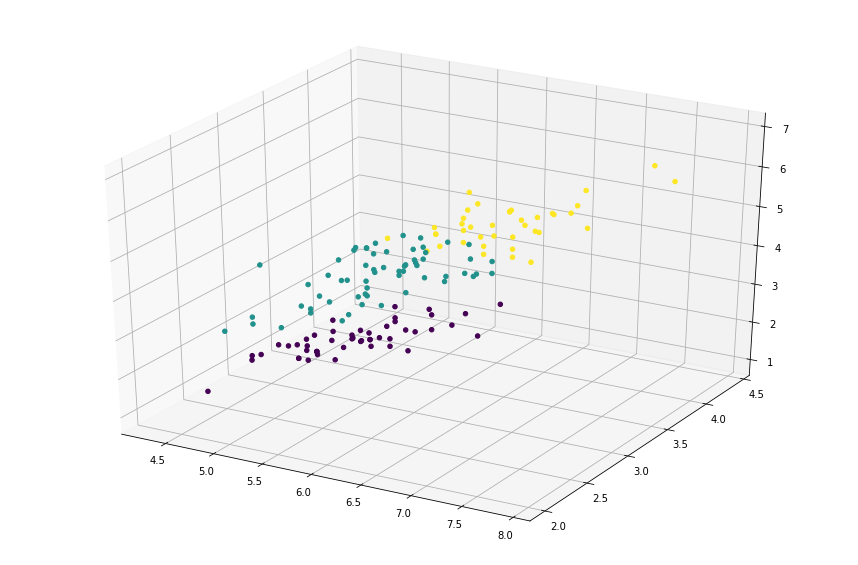

In [25]:
cluster_vis = plt.figure(figsize=(15,10)).gca(projection='3d')
cluster_vis.scatter(pandas_df.sepal_length, pandas_df.sepal_width, pandas_df.petal_length, c=pandas_df.prediction,depthshade=False)
plt.show()